<a href="https://colab.research.google.com/github/rtaglega53/pedropicapiedra/blob/master/Okcupid.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **Raul Antonio Tagle Garcia **

Reconocimiento de Patrones 

Proyecto de recomendación de parejas utilzando BD de OKCUPID del estado de California

El proyecto basa en la agrupación de las personas en base a cierta información que comparten cuando hacen su perfil, los campos que vamos a usar son los siguientes:

-drinks

-drugs

-job

-orientation

-age

-pets

-religion

-sex

-smokes


Se quedan pendientes educacion,  la decendencia que tienen(hijos y preferencias)y el body type



Primero importamos todas las librerias que estaremos utlizando en el proyecto

In [2]:
# librerias para manejo de datos y graficas
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import time
import warnings
# librerias para clustering
from sklearn import cluster, datasets, mixture, metrics
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import silhouette_samples, silhouette_score
# librerias para busqueda de hiperparametros
from sklearn import metrics, preprocessing, tree
from sklearn.metrics import f1_score, make_scorer
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier as dt
from sklearn.model_selection import KFold
# librerias para PCA
from sklearn.model_selection import train_test_split
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn import svm, metrics
warnings.filterwarnings("ignore")


Leemos los datos

In [3]:
# no se necesita cargar todo el tiempo
uploaded = files.upload()
df = pd.read_csv('okcupid_california_4.csv')
df.head()



Saving okcupid_california_4.csv to okcupid_california_4.csv


,age,body_type,diet,drinks,drugs,education,ethnicity,height,income,job,last_online,location,offspring,orientation,pets,religion,sex,sign,smokes,speaks,status,Unnamed: 21
0,22,a little extra,anything,socially,never,working on college/university,asian,75,?,non_stem,2012-06-28-20-30,"south san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism,m,gemini,sometimes,english,single,NaN
1,35,average,anything,often,sometimes,working on space camp,white,70,80000,non_stem,2012-06-29-21-41,"oakland, california","doesn&rsquo;t have kids, but might want them",straight,likes dogs and likes cats,agnosticism,m,cancer,no,"english (fluently), spanish (poorly), french (...",single,NaN
2,23,thin,vegetarian,socially,?,working on college/university,white,71,20000,student,2012-06-28-14-22,"berkeley, california",doesn&rsquo;t want kids,straight,likes cats,?,m,pisces,no,"english, german (poorly)",single,NaN
3,29,athletic,?,socially,never,graduated from college/university,asian,66,?,non_stem,2012-06-27-21-26,"san francisco, california",?,straight,likes dogs and likes cats,?,m,aquarius,no,english,single,NaN
4,29,average,anything,socially,?,graduated from college/university,white,67,?,stem,2012-06-29-19-18,"san francisco, california","doesn&rsquo;t have kids, but might want them",straight,likes cats,atheism,m,taurus,no,"english (fluently), chinese (okay)",single,NaN


Lo primero que tenemos es limpiar nuestros datos, quitamos las columnas que no vamos a utilizar

---



In [4]:
# utilizamos metodo copy para poder jugar con los valors sin tener que cargar el archivo
genero = df[['sex']]
df_copy = df.drop(columns=['location', 'height', 'income', 'last_online', 'sign', 'status', 'education', 'body_type' , 'speaks', 'pets','offspring', 'Unnamed: 21', 'sex']).copy()
# df_copy = df.drop(columns=['location', 'height', 'income', 'last_online', 'sign', 'status']).copy() # version
df_copy.head()



,age,diet,drinks,drugs,ethnicity,job,orientation,religion,smokes
0,22,anything,socially,never,asian,non_stem,straight,agnosticism,sometimes
1,35,anything,often,sometimes,white,non_stem,straight,agnosticism,no
2,23,vegetarian,socially,?,white,student,straight,?,no
3,29,?,socially,never,asian,non_stem,straight,?,no
4,29,anything,socially,?,white,stem,straight,atheism,no


Guardamos el vector de Genero, ya que este nos ayudara en el futuro cuando queramos hacer las recomendaciones

In [5]:
genero.head()

,sex
0,m
1,m
2,m
3,m
4,m


Tenemos puros datos categoricos, por lo que tenemos que vovlerlos continuos



Las variables categoricas se tienen que transformar a varibles continuas, tomo un criterio propio para agrupar algunas, e intentando jerarquizar de mayor a menor.  Aqui puedo notar como se puede manipular a la sociedad, si por tu critierio los juntas y siemplemente les aparen más, puedes crear una tendencia.

In [7]:
transform_data = {  # age is continue data
    "sex":{"m":0,"f":1}, 
    "drinks":{"?":0,"not at all":1, "rarely":2, "socially":3,"often":4, "very often":5 , "desperately": 6},
    "drugs":{"?":0,"sometimes":1, "often":2, "never":3,},
    "job":{"non_stem":0,"stem":1, "student":2,},
    "orientation":{"bisexual":0,"gay":1, "straight":2,},
    "pets":{"?":0,"not at all":1, "rarely":2, "socially":3,"often":4, "very often":5 , "desperately": 6}, ##
    "smokes":{"?":0,"no":2, "sometimes":3,"trying to quit":4, "when drinking":5 , "yes": 6},
    "diet":{"?":0,"anything":1, "halal":2, "vegetarian":3,"vegan":4, "kosher":5 },   
    "religion":{"?":0,"other":0, "agnosticism":2, "atheism":3,"christianity":4, "catholicism":5, "hinduism":6, "buddhism":7, "judaism":8, "islam":9,},  
    "ethnicity":{"?":0,"other":0, "asian":2, "hispanic":3,"indian":4, "middle":5, "pacific":6, "white":7, "black":8,"native":9 },   
    # "pets":{"?":0,"asian":1, "indian":2, "hispanic":3 , "pacific islander": 4, "white": 4}, ##    
    } 

#labels_sex = df_copy['sex'].astype('category').cat.categories.tolist()
#print(labels)  # encontrar como guardar las etiquetas

for key, item in transform_data.items():
  print(key, item)
  df_copy = df_copy.replace({key:item})
df_copy.head()

sex {'m': 0, 'f': 1}
drinks {'?': 0, 'not at all': 1, 'rarely': 2, 'socially': 3, 'often': 4, 'very often': 5, 'desperately': 6}
drugs {'?': 0, 'sometimes': 1, 'often': 2, 'never': 3}
job {'non_stem': 0, 'stem': 1, 'student': 2}
orientation {'bisexual': 0, 'gay': 1, 'straight': 2}
pets {'?': 0, 'not at all': 1, 'rarely': 2, 'socially': 3, 'often': 4, 'very often': 5, 'desperately': 6}
smokes {'?': 0, 'no': 2, 'sometimes': 3, 'trying to quit': 4, 'when drinking': 5, 'yes': 6}
diet {'?': 0, 'anything': 1, 'halal': 2, 'vegetarian': 3, 'vegan': 4, 'kosher': 5}
religion {'?': 0, 'other': 0, 'agnosticism': 2, 'atheism': 3, 'christianity': 4, 'catholicism': 5, 'hinduism': 6, 'buddhism': 7, 'judaism': 8, 'islam': 9}
ethnicity {'?': 0, 'other': 0, 'asian': 2, 'hispanic': 3, 'indian': 4, 'middle': 5, 'pacific': 6, 'white': 7, 'black': 8, 'native': 9}


,age,diet,drinks,drugs,ethnicity,job,orientation,religion,smokes
0,22,1,3,3,2,0,2,2,3
1,35,1,4,1,7,0,2,2,2
2,23,3,3,0,7,2,2,0,2
3,29,0,3,3,2,0,2,0,2
4,29,1,3,0,7,1,2,3,2


Creamos la funcion de nuestro modelo, en este caso será kmeans


9
[0 4 3 ... 1 0 1]


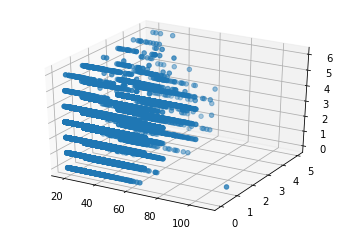

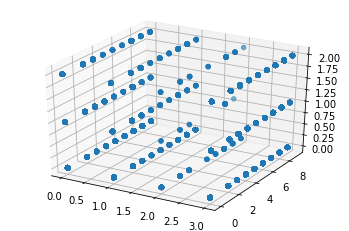

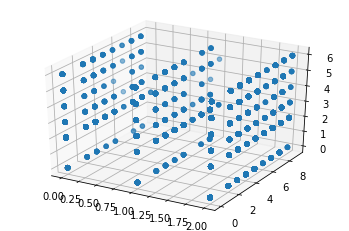

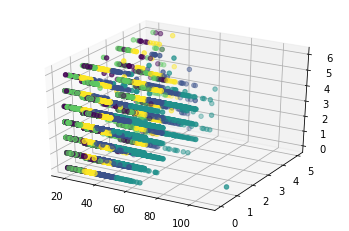

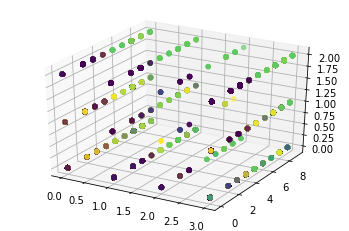

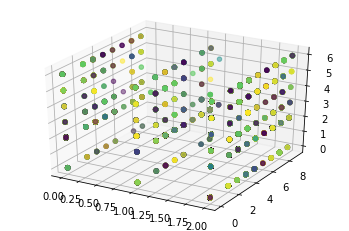

In [10]:
x = np.asanyarray(df_copy)
print (len(x[0]))
kmeans = cluster.KMeans(n_clusters = 5, random_state = 0)
kmeans.fit(x)
labels = kmeans.predict(x)
print(labels)
## Dibujar

fig = plt.figure() 
# ax = plt.subplot(2, 2, 1)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1],  x[:,2],)
fig = plt.figure() 
# ax = plt.subplot(2, 3, 2)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,3], x[:,4],  x[:,5],)
fig = plt.figure() 
# ax = plt.subplot(2, 3, 3)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,6], x[:,7],  x[:,8],)
fig = plt.figure()
#ax = plt.subplot(2, 3, 4)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,0], x[:,1],x[:,2],c=kmeans.predict(x))
fig = plt.figure()
# ax = plt.subplot(2, 3, 5)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,3], x[:,4],x[:,5],c=kmeans.predict(x))
fig = plt.figure()
# ax = plt.subplot(2, 3, 6)
ax = fig.add_subplot(111, projection='3d')
ax.scatter(x[:,6], x[:,7],x[:,8],c=kmeans.predict(x))


def kmeans_silhouette(data, n_clusters):
  
  clusterer = cluster.KMeans(n_clusters=n_clusters)
  cluster_labels = clusterer.fit_predict(data)
  silhouette_avg = silhouette_score(data, cluster_labels)
  print("For n_clusters =", n_clusters,
  "The average Kmean_silhouette_score is :", silhouette_avg)
  sample_silhouette_values = silhouette_samples(data, cluster_labels)
  return silhouette_avg

Debido a que con 9 dimensiones es complicado analizar el problemas, pasaremos a usar un PCA para reducir la dimensionalidad 

Primero se reduce a dimensionalidad 2

In [12]:
model = TSNE(n_components=3, n_iter=2000, n_jobs=-1)
x_2d = model.fit_transform(x)
x_2d.shape

(50789, 2)

Procedemos a graficarlo

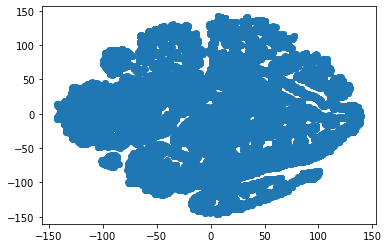

In [15]:
plt.scatter(x_2d[:,0],x_2d[:,1],  cmap=plt.cm.tab10)

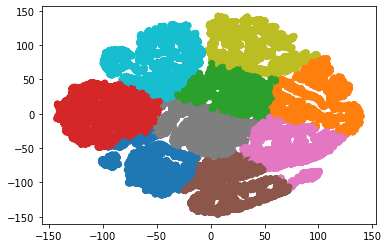

In [21]:
kmeans = cluster.KMeans(n_clusters = 9, random_state = 0)
kmeans.fit(x_2d)
labels = kmeans.predict(x_2d)
plt.scatter(x_2d[:,0],x_2d[:,1],c=labels,  cmap=plt.cm.tab10)

Ahora a dimensionalidad 3

Sacamos los coeficientes de 2 a 10 clases para ver los mejores resultados

In [ ]:
model_3 = TSNE(n_components=3, n_iter=2000, n_jobs=-1)
x_3d = model.fit_transform(x)
x_3d.shape

In [ ]:
scores = []
classes = [5,10,20,30,40]
for each in classes:
  sil = kmeans_silhouette(x,each)
  scores.append(sil)
plt.xlabel("Cluster number")
plt.ylabel("Scores")
plt.title("spectral Scores vs Clusters analysis")
plt.bar(classes,scores)
scores = []
classes = [2,4,5,8,10]
plt.xlabel("Cluster number")
plt.ylabel("Scores")
plt.title("spectral Scores vs Clusters analysis")
plt.show()

For n_clusters = 5 The average Kmean_silhouette_score is : 0.2624343706315055


Funcion para agrupar



In [16]:
from sklearn.metrics import silhouette_samples, silhouette_score

def calculate_silhouette(data, n_clusters, type):
  plt.figure
  plt.xlim([-0.1, 1])
  if type == 'KMeans':
    clusterer = cluster.KMeans(n_clusters=n_clusters, random_state = 0 )
  elif type == 'SpectralClustering':
    clusterer = cluster.SpectralClustering(n_clusters=n_clusters, affinity="nearest_neighbors")
  elif type == 'GaussianMixture':
    clusterer = mixture.GaussianMixture(n_components=n_clusters, covariance_type='full')
  elif type == 'OPTICS':
     clusterer = cluster.OPTICS(min_samples=20, xi=0.05, min_cluster_size=0.1)

  cluster_labels = clusterer.fit_predict(data)
  silhouette_avg = silhouette_score(data, cluster_labels)
  print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

  sample_silhouette_values = silhouette_samples(data, cluster_labels)

  y_lower = 10
  for i in range(n_clusters):
    # Aggregate the silhouette scores for samples belonging to
    # cluster i, and sort them
    ith_cluster_silhouette_values = \
    sample_silhouette_values[cluster_labels == i]

    ith_cluster_silhouette_values.sort()

    size_cluster_i = ith_cluster_silhouette_values.shape[0]
    y_upper = y_lower + size_cluster_i

    color = plt.cm.nipy_spectral(float(i) / n_clusters)
    plt.fill_betweenx(np.arange(y_lower, y_upper),
                      0, ith_cluster_silhouette_values,
                      facecolor=color, edgecolor=color, alpha=0.7)

    # Label the silhouette plots with their cluster numbers at the middle
    plt.text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))

    # Compute the new y_lower for next plot
    y_lower = y_upper + 10  # 10 for the 0 samples

    plt.title("The silhouette plot for the various clusters.")
    plt.xlabel("The silhouette coefficient values")
    plt.ylabel("Cluster label")

    # The vertical line for average silhouette score of all the values
    plt.axvline(x=silhouette_avg, color="red", linestyle="--")

    plt.yticks([])  # Clear the yaxis labels / ticks
    plt.xticks([-0.1, 0, 0.2, 0.4, 0.6, 0.8, 1])
  plt.show()

For n_clusters = 2 The average silhouette_score is : 0.5056281305369651


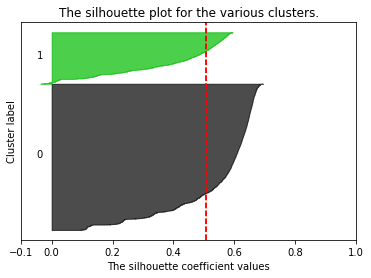

For n_clusters = 5 The average silhouette_score is : 0.25997227631648934


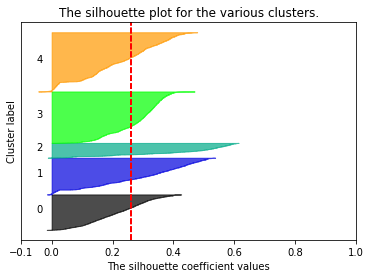

For n_clusters = 10 The average silhouette_score is : 0.22645620916588657


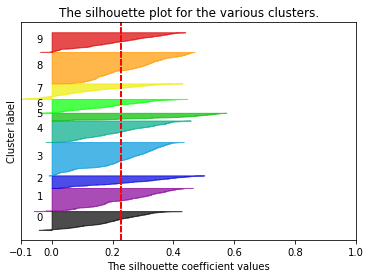

In [184]:
calculate_silhouette(x, 2, 'KMeans')
calculate_silhouette(x, 5, 'KMeans')
calculate_silhouette(x, 10, 'KMeans')

For n_clusters = 2 The average silhouette_score is : 0.004772961979749671


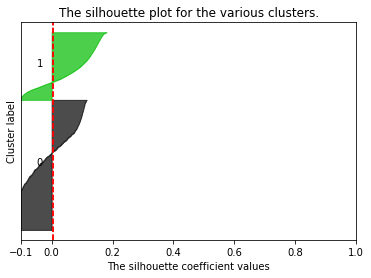

For n_clusters = 5 The average silhouette_score is : -0.07366071932034472


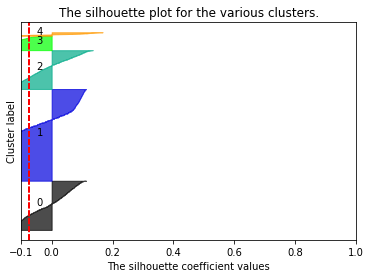

For n_clusters = 10 The average silhouette_score is : -0.134984959041623


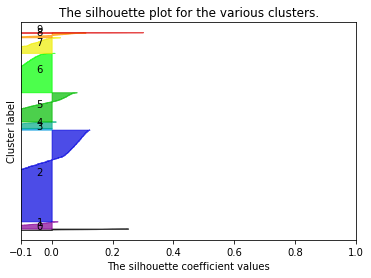

In [179]:
# spectral

calculate_silhouette(x, 2, 'GaussianMixture')
calculate_silhouette(x, 5, 'GaussianMixture')
calculate_silhouette(x, 10, 'GaussianMixture')

For n_clusters = 2 The average silhouette_score is : -0.04251967613782064


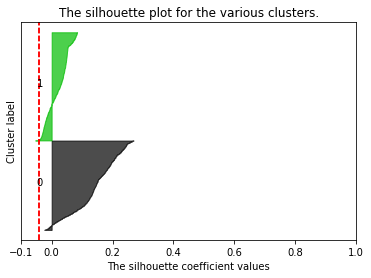

For n_clusters = 5 The average silhouette_score is : -0.04251967613782064


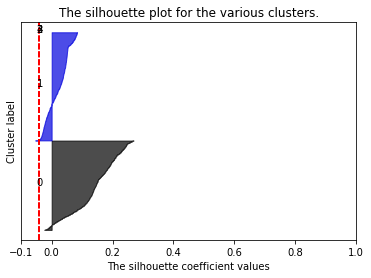

For n_clusters = 10 The average silhouette_score is : -0.04251967613782064


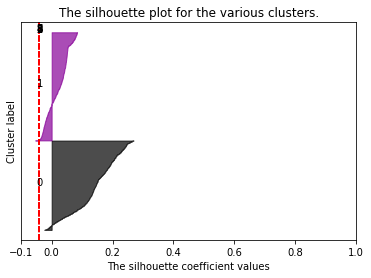

In [182]:
calculate_silhouette(x, 2, 'OPTICS')


Despues de encontrar las clases que mas se nos acomodan de acuerdo a nuestros coeficientes, vamos a utilizar el genero de cada uno para recomendar a otros de ese mismo grupo pero dependiendo a su orientación.

For n_clusters = 2 The average silhouette_score is : 0.34377584


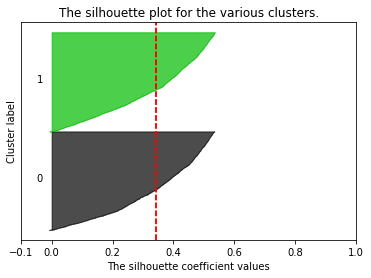

For n_clusters = 5 The average silhouette_score is : 0.34699494


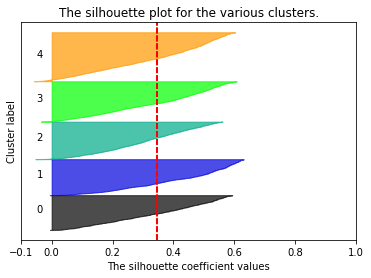

For n_clusters = 10 The average silhouette_score is : 0.36437517


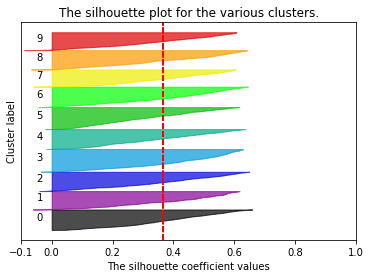

In [17]:
calculate_silhouette(x_2d, 20, 'KMeans')
calculate_silhouette(x_2d, 40, 'KMeans')
calculate_silhouette(x_2d, 50, 'KMeans')